# 4. Model Training and Comparison

In this notebook, we train multiple classification models to detect fraud and compare their performance using various metrics.

In [35]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.data.loading import load_fraud_data
from src.models.data_prep import prepare_model_data
from src.models.baseline import LogisticRegressionBaseline
from src.models.ensemble import RandomForestModel, XGBoostModel, LightGBMModel
from src.models.evaluation import calculate_metrics, stratified_kfold_cv, aggregate_cv_results, save_model
from src.models.comparison import compare_models, create_comparison_table, select_best_model
from src.visualization.model_viz import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve, plot_feature_importance, plot_model_comparison

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Prepare Data

Loading the featured dataset and splitting into train/test sets with preprocessing.

In [36]:
# Load processed data
df = pd.read_csv('../data/processed/fraud_featured.csv')

print(f"Loaded data shape: {df.shape}")

# Define target and columns to exclude
target = 'class'
drop_cols = [
    'user_id', 'signup_time', 'purchase_time', 'device_id',
    'ip_address', 'country', 'ip_int',
    'lower_bound_ip_address', 'upper_bound_ip_address'
]

# Identify and encode categorical columns
categorical_cols = ['source', 'browser', 'sex', 'time_of_day']
available_cats = [c for c in categorical_cols if c in df.columns]
print(f"Encoding categorical columns: {available_cats}")

df = pd.get_dummies(df, columns=available_cats, drop_first=True)
print(f"Shape after encoding: {df.shape}")

# Handle missing values (from feature engineering)
# Fill NaN values with 0 (reasonable for time-based features)
nan_counts = df.isna().sum()
if nan_counts.sum() > 0:
    print(f"\nFilling {nan_counts.sum()} missing values...")
    print(f"Columns with NaNs: {list(nan_counts[nan_counts > 0].index)}")
    df.fillna(0, inplace=True)

# Prepare data for modeling
X_train, X_test, y_train, y_test = prepare_model_data(
    df,
    target,
    exclude_cols=drop_cols,
    test_size=0.2
)

print(f"\nFinal shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

Loaded data shape: (129146, 28)
Encoding categorical columns: ['source', 'browser', 'sex', 'time_of_day']
Shape after encoding: (129146, 34)

Filling 258292 missing values...
Columns with NaNs: ['time_since_last_txn', 'avg_time_between_txn']
2025-12-28 19:36:57 - fraud_detection - INFO - Starting complete data preparation pipeline...
2025-12-28 19:36:57 - fraud_detection - INFO - Separating features from target 'class'...
2025-12-28 19:36:57 - fraud_detection - INFO - Features: 24 columns
2025-12-28 19:36:57 - fraud_detection - INFO - Target: class
2025-12-28 19:36:57 - fraud_detection - INFO - Total samples: 129146
2025-12-28 19:36:57 - fraud_detection - INFO - Performing stratified train-test split (test_size=0.2)...
2025-12-28 19:36:57 - fraud_detection - INFO - Training set: 103316 samples
2025-12-28 19:36:57 - fraud_detection - INFO - Test set: 25830 samples
2025-12-28 19:36:57 - fraud_detection - INFO - Train class distribution:
class
0    0.90501
1    0.09499
Name: proportion, d

## 2. Model Training & Evaluation

In [37]:
results = []

# --- 1. Baseline: Logistic Regression ---
print("Training Logistic Regression...")
lr = LogisticRegressionBaseline()
lr.train(X_train, y_train)
lr_metrics = lr.evaluate(X_test, y_test)
results.append(lr_metrics)

# --- 2. Random Forest ---
print("Training Random Forest...")
rf = RandomForestModel()
rf.train(X_train, y_train)
rf_metrics = rf.evaluate(X_test, y_test)
results.append(rf_metrics)

# --- 3. XGBoost ---
print("Training XGBoost...")
xgb = XGBoostModel()
xgb.train(X_train, y_train)
xgb_metrics = xgb.evaluate(X_test, y_test)
results.append(xgb_metrics)

# --- 4. LightGBM ---
print("Training LightGBM...")
lgbm = LightGBMModel()
lgbm.train(X_train, y_train)
lgbm_metrics = lgbm.evaluate(X_test, y_test)
results.append(lgbm_metrics)

Training Logistic Regression...
2025-12-28 19:36:57 - fraud_detection - INFO - Initialized Logistic Regression with params: {'max_iter': 1000, 'random_state': 42, 'class_weight': 'balanced'}
2025-12-28 19:36:57 - fraud_detection - INFO - Training Logistic Regression...
2025-12-28 19:36:59 - fraud_detection - INFO - Logistic Regression training complete
2025-12-28 19:36:59 - fraud_detection - INFO - Evaluating Logistic Regression...
2025-12-28 19:36:59 - fraud_detection - INFO - 
Logistic Regression Metrics:
2025-12-28 19:36:59 - fraud_detection - INFO -   accuracy: 0.7377
2025-12-28 19:36:59 - fraud_detection - INFO -   precision: 0.2171
2025-12-28 19:36:59 - fraud_detection - INFO -   recall: 0.6756
2025-12-28 19:36:59 - fraud_detection - INFO -   f1: 0.3286
2025-12-28 19:36:59 - fraud_detection - INFO -   roc_auc: 0.7787
2025-12-28 19:36:59 - fraud_detection - INFO -   auc_pr: 0.6149
2025-12-28 19:36:59 - fraud_detection - INFO - 
Logistic Regression Classification Report:
2025-12-28

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


2025-12-28 19:37:11 - fraud_detection - INFO - XGBoost training complete
2025-12-28 19:37:11 - fraud_detection - INFO - Evaluating XGBoost...
2025-12-28 19:37:12 - fraud_detection - INFO - 
XGBoost Metrics:
2025-12-28 19:37:12 - fraud_detection - INFO -   accuracy: 0.9573
2025-12-28 19:37:12 - fraud_detection - INFO -   precision: 1.0000
2025-12-28 19:37:12 - fraud_detection - INFO -   recall: 0.5505
2025-12-28 19:37:12 - fraud_detection - INFO -   f1: 0.7101
2025-12-28 19:37:12 - fraud_detection - INFO -   roc_auc: 0.7795
2025-12-28 19:37:12 - fraud_detection - INFO -   auc_pr: 0.6449
2025-12-28 19:37:12 - fraud_detection - INFO - 
XGBoost Classification Report:
2025-12-28 19:37:12 - fraud_detection - INFO - 
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     23376
           1       1.00      0.55      0.71      2454

    accuracy                           0.96     25830
   macro avg       0.98      0.78      0.84     25830
weighted

## 3. Comparison and Selection

In [38]:
comparison_df = compare_models(results, sort_by='auc_pr')
comparison_table = create_comparison_table(results)
print(comparison_table)

best = select_best_model(results, primary_metric='auc_pr')
print(best['justification'])

2025-12-28 19:37:13 - fraud_detection - INFO - Comparing models...
2025-12-28 19:37:13 - fraud_detection - INFO - 
Model Comparison (sorted by auc_pr):
2025-12-28 19:37:13 - fraud_detection - INFO - 
 accuracy  precision   recall       f1  roc_auc   auc_pr          model_name
 0.957298   1.000000 0.550530 0.710118 0.779546 0.645928       Random Forest
 0.957298   1.000000 0.550530 0.710118 0.779533 0.644855             XGBoost
 0.956562   0.985423 0.550937 0.706743 0.779349 0.643208            LightGBM
 0.737747   0.217129 0.675632 0.328642 0.778673 0.614860 Logistic Regression
                 Model ACCURACY PRECISION  RECALL      F1 ROC_AUC  AUC_PR
0  Logistic Regression   0.7377    0.2171  0.6756  0.3286  0.7787  0.6149
1        Random Forest   0.9573    1.0000  0.5505  0.7101  0.7795  0.6459
2              XGBoost   0.9573    1.0000  0.5505  0.7101  0.7795  0.6449
3             LightGBM   0.9566    0.9854  0.5509  0.7067  0.7793  0.6432
2025-12-28 19:37:13 - fraud_detection - INFO 

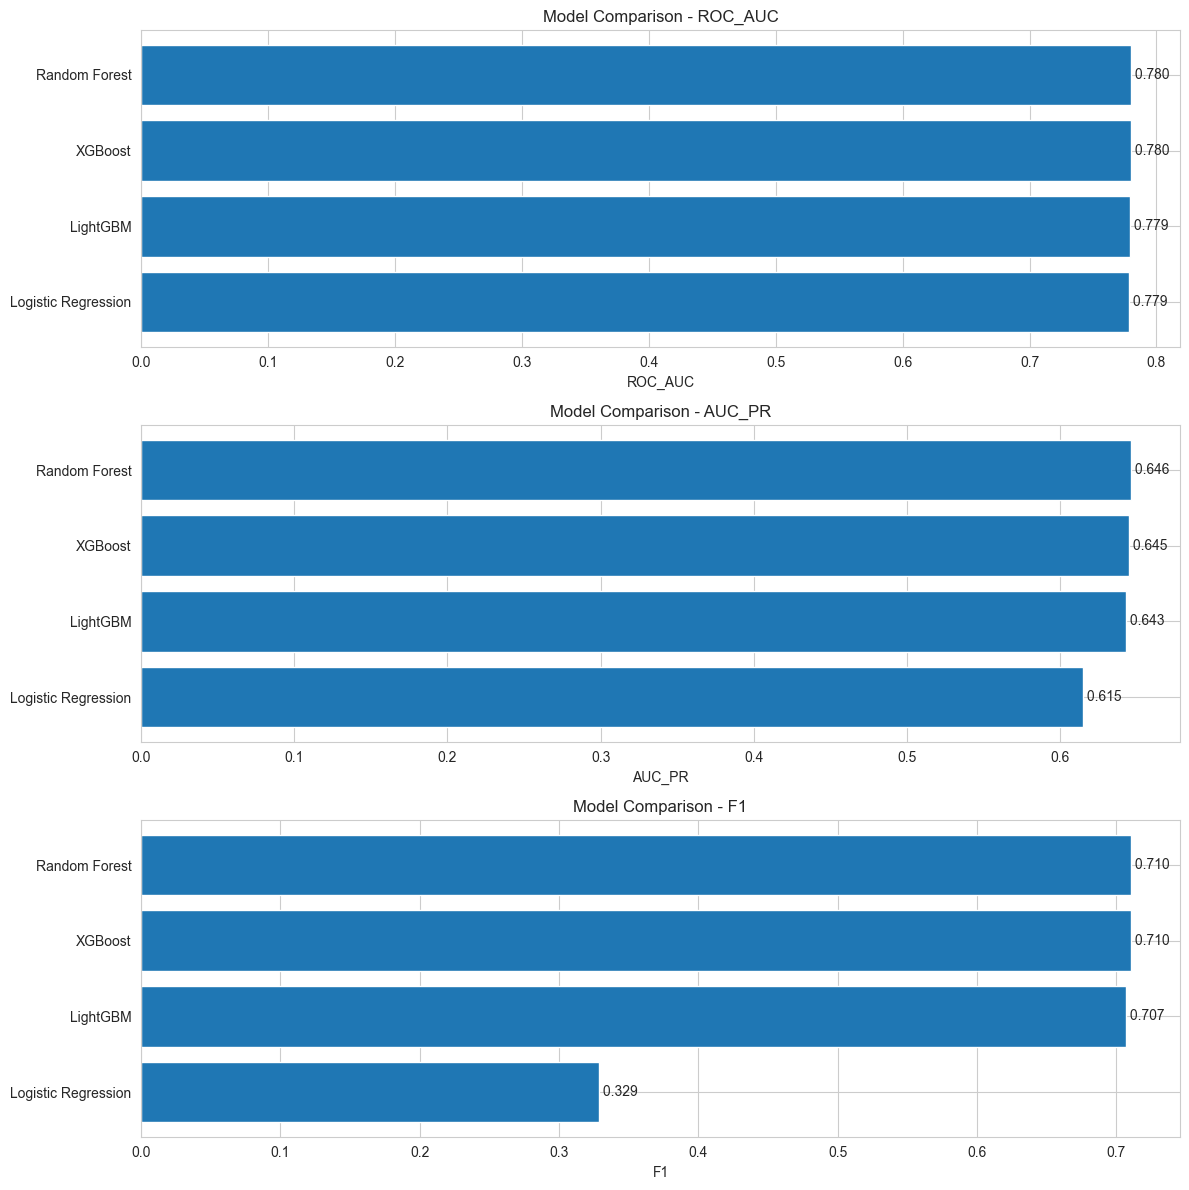

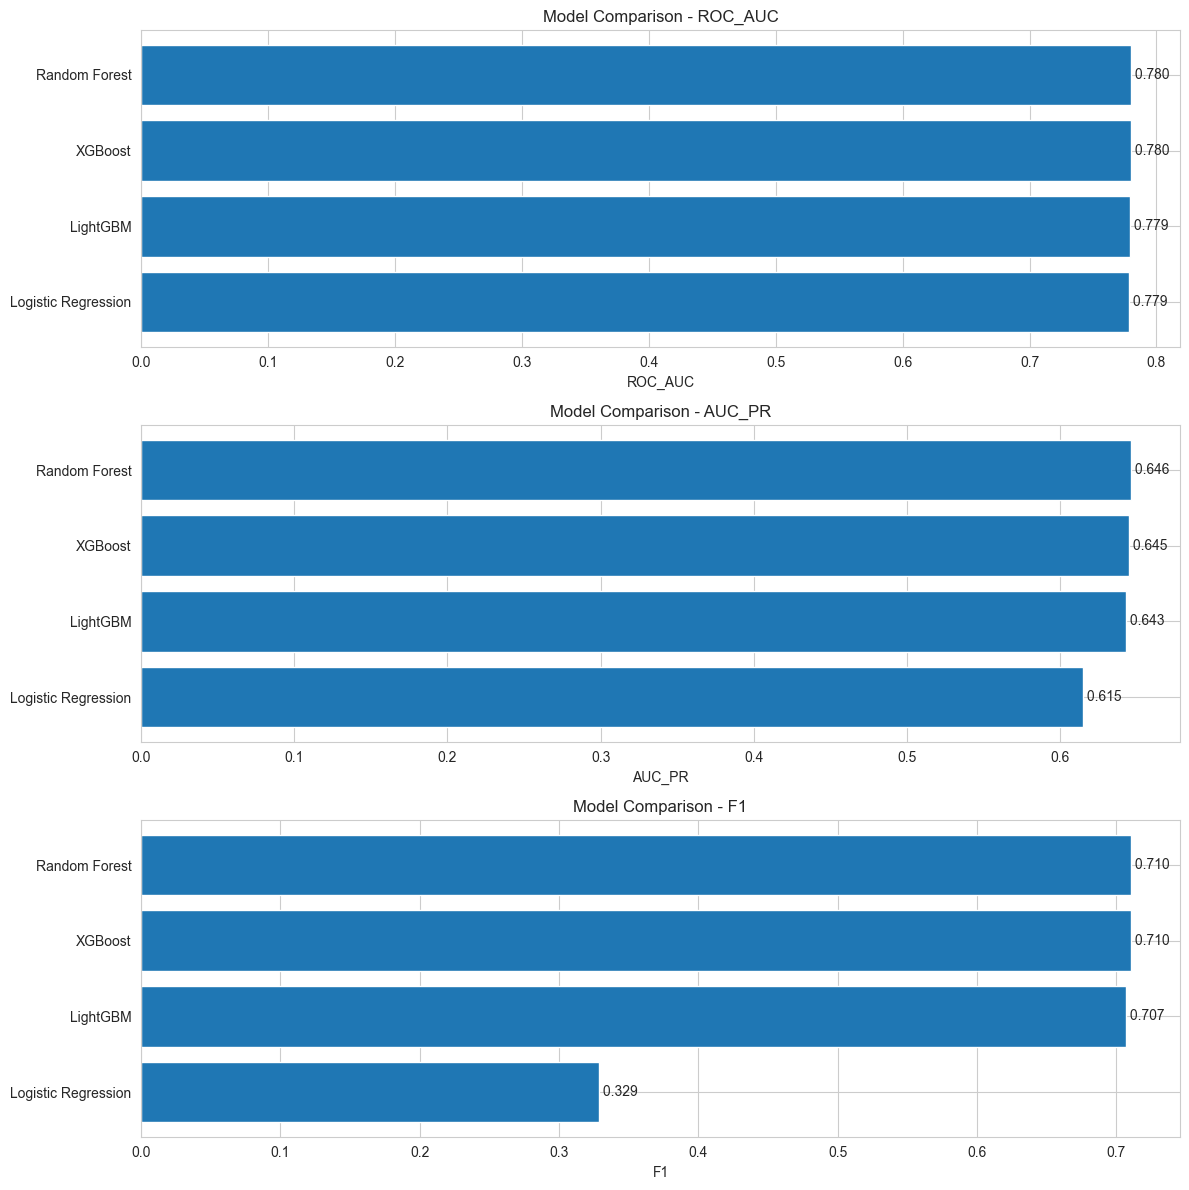

In [39]:
plot_model_comparison(comparison_df, metrics=['roc_auc', 'auc_pr', 'f1'])

## 4. Visualization for Best Model

Let's assume XGBoost or LightGBM performed best.

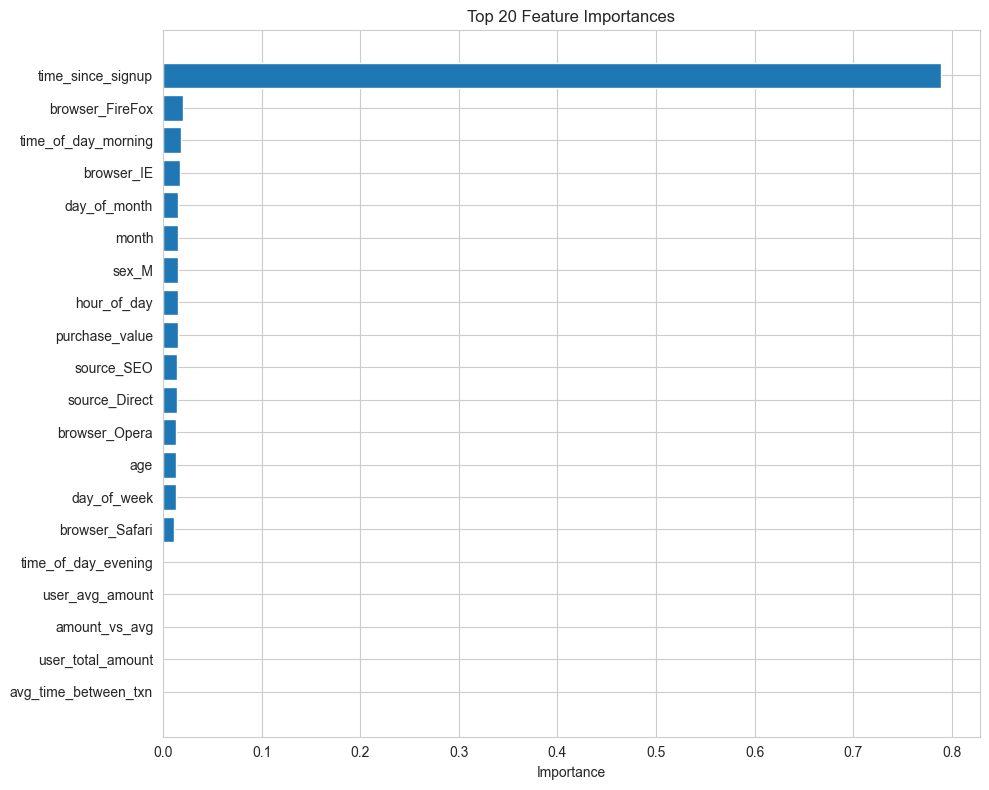

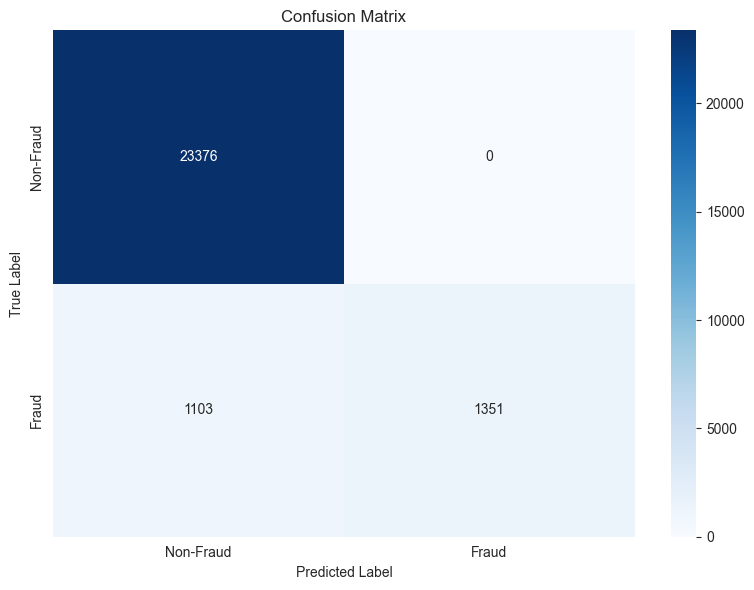

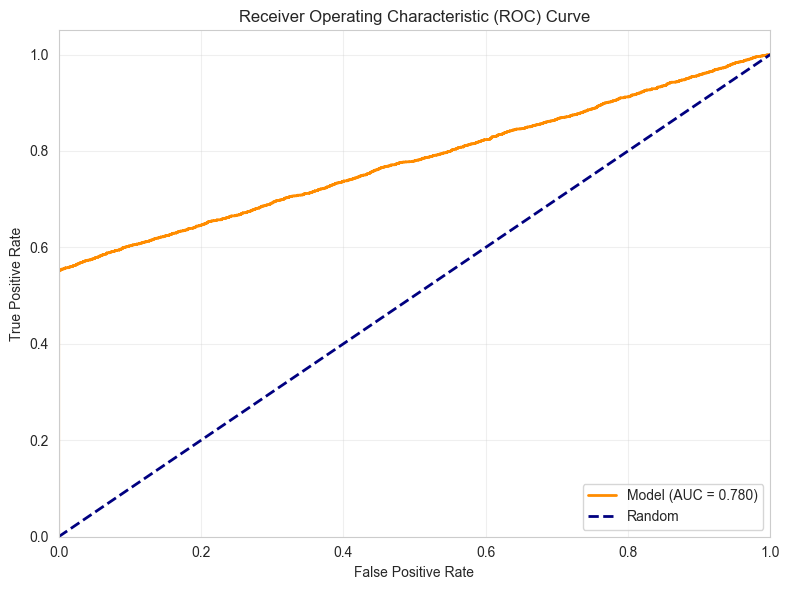

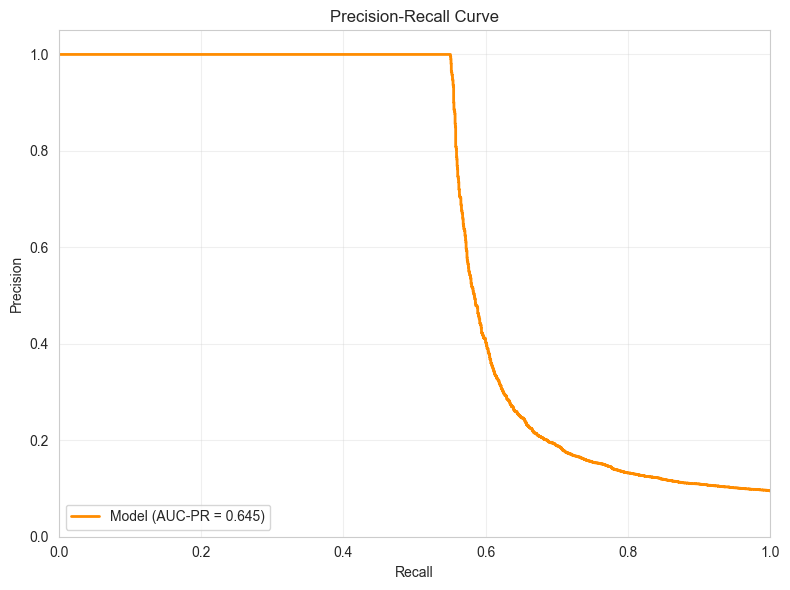

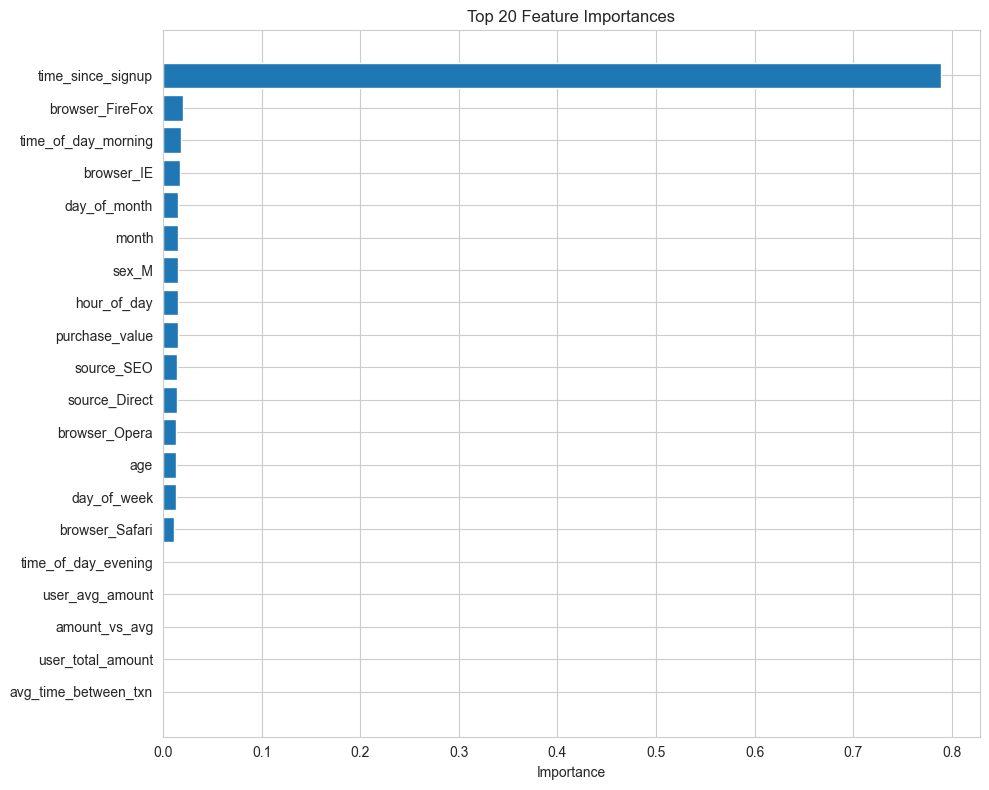

In [41]:
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)

plot_confusion_matrix(y_test, y_pred)
plot_roc_curve(y_test, y_proba)
plot_precision_recall_curve(y_test, y_proba)
plot_feature_importance(xgb.model, X_train.columns)

## 5. Save the Best Model

In [42]:
save_model(xgb.model, "best_fraud_model")
print("Best model saved to models/best_fraud_model.joblib")

2025-12-28 19:38:46 - fraud_detection - INFO - Saved model to C:\Users\Lenovo\Documents\dawir\Fraud-Detection\models\best_fraud_model.joblib
Best model saved to models/best_fraud_model.joblib
